In [86]:
! pip install tabulate


In [87]:
! pip install pyamaze

imports

In [88]:
from tabulate import tabulate
from shutil import get_terminal_size
from collections import deque
import time
import sys
from heapq import heappop, heappush
from pyamaze import maze, agent, COLOR, textLabel
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from random import randint, choice, random
from math import exp
from itertools import count


__heuristics__

In [89]:
def heuristic_2(current, goal):
    return abs(current[0] - goal[0]) + abs(current[1] - goal[1])

In [90]:
def heuristic(a, b):
     return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

# __problem__

In [91]:
class Node:
    def __init__(self, position, path_cost=1):
        self.start = False  # start at position (0, 0)
        self.goal = False
        self.position = position
        self.children = []
        self.go = True  # is there an obstacle or not
        self.path_cost = path_cost
        self.heuristic = None
        self.parent = None  # Add parent attribute

    def __lt__(self, other):
        return self.heuristic < other.heuristic

    def is_part_of_solution(self, solution):
        return self.position in solution

def tree_creation(row, col):
    tree = {}

    for i in range(row):
        for j in range(col):
            tree[(i, j)] = Node((i, j))  # grid of 4x4

    for i in range(row):
        for j in range(col):
            node = tree[(i, j)]  # current node

            if node.go:
                neighbors = [
                    (i, j + 1),  # below
                    (i, j - 1),  # above
                    (i + 1, j),  # right
                    (i - 1, j),  # left
                    # (i - 1, j - 1),  # top-left diagonal
                    # (i - 1, j + 1),  # bottom-left diagonal
                    # (i + 1, j - 1),  # top-right diagonal
                    # (i + 1, j + 1)  # bottom-right diagonal
                ]
                for nx, ny in neighbors:  # check limits of x and y
                    if 0 <= nx < row and 0 <= ny < col:
                        neighbor_node = tree[(nx, ny)]
                        if neighbor_node.go:
                            node.children.append(neighbor_node)

    tree[0, 0].start = True
    while True:
        goal_position = (randint(0, row - 1), randint(0, col - 1))
        if goal_position != (0, 0):  # Ensure the goal is not at the start
            break
    tree[goal_position].goal = True

    return tree

def building(tree, row, col):  # the obstacle
    building_count = 0
    building_per = int(0.15 * (row * col))  # 160 building

    while building_count < building_per:
        i = randint(0, row - 1)  # 3shan (0, 0) heya el start
        j = randint(0, col - 1)
        building_node = tree[(i, j)]

        if building_node.go and not building_node.goal and not building_node.start:
            building_node.go = False
            building_node.path_cost = float('inf')  # Impassable
            building_count += 1

    return tree

def assign_cost(tree, row, col):
    for i in range(row):
        for j in range(col):
            node = tree[(i, j)]
            if node.go and not node.goal and not node.start:
                node.path_cost = choice([1, 2])  # 1 -> tree, 2 -> car


visualizer

In [92]:
# Get the terminal width
terminal_width, _ = get_terminal_size()

# Dictionary to store visualizer functions for different problem types
_visualizers = {}

# Default visualizer function
def _default_visualizer(_, state):
    '''Generic visualizer for unknown problems.'''
    print(state)

# Visualizer class
class Visualizer:
    '''Visualization and printing functionality encapsulation.'''

    def __init__(self, problem):
        '''Constructor with the problem to visualize.'''
        self.problem = problem
        self.counter = 0

    def visualize(self, frontier):
        '''Visualizes the frontier at every step.'''
        self.counter += 1
        print(f'Frontier at step {self.counter}')
        for node in frontier:
            print()
            _visualizers.get(type(self.problem), _default_visualizer)(self.problem, node)
        print('-' * terminal_width)

# Custom visualizer for the Node class
def node_visualizer(_, node):
    '''Visualizer for Node objects.'''
    print(f'Position: {node.position}, Path Cost: {node.path_cost}, Heuristic: {node.heuristic}, Goal: {node.goal}, Start: {node.start}, Go: {node.go}')

# Register the custom visualizer for the Node class
_visualizers[Node] = node_visualizer


performane measuring

In [93]:
def measure_performance(search_algorithm, problem, start_position, goal_position, verbose=False):
    """
    Wrapper function to measure the time and space performance of the search algorithm.
    """
    # Start measuring time
    start_time = time.time()

    # Run the search algorithm, capturing the solution and max frontier size
    solution_result, max_frontier_size = search_algorithm(problem, start_position, goal_position, verbose=verbose)

    # Measure elapsed time
    elapsed_time = time.time() - start_time

    return {
        'solution': solution_result,
        'elapsed_time': elapsed_time,
        'max_frontier_size': max_frontier_size  # Return the max number of nodes in the frontier
    }


# __A*__

In [94]:
def astar_search(tree, start_position, goal_position, h=None, verbose=False):
    """A* search with optional verbose output."""
    if h is None:
        h = heuristic
    #defining the heuristic in A*

    start_node = tree[start_position]
    # the initial state (starting point)

    start_node.heuristic = h(start_node.position, goal_position)
    frontier = [(start_node.heuristic, 0, start_node)]  
    # Priority queue ordered by (f(n), tiebreaker, node)
    
    explored = set()
    max_frontier_size = 1  
    # Track the maximum size of the frontier

    if verbose:
        print("Starting A* ----->> ")

    while frontier:
        _, _, node = heappop(frontier)
        if node.goal:
            return solution(node), max_frontier_size
        #check if the current node(state) is the goal

        explored.add(node.position)
        # adds the node to the explored Q
        for child in node.children:
            if not child.go:
            # avoid obsticle
                continue
            f = node.path_cost + h(child.position, goal_position)
            # F(n) = h(n) + Path cost
            child.heuristic = f  
            # Set the heuristic value for the child node
            if child.position not in explored and all(c.position != child.position for _, _, c in frontier):
                child.parent = node  
                # Set the parent of the child node

                heappush(frontier, (f, len(explored), child))  
                # Use len(explored) as a tiebreaker

                if child.goal: # current child is goal state ?
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            print(f"Frontier size: {len(frontier)}")
    return None, max_frontier_size

def solution(node):
    path = []
    while node is not None:
        path.append(node.position)
        node = node.parent
    return path[::-1]


# __Greedy best first__

In [95]:
def Greedy_best_firsy_search(tree, start_position, goal_position, h=None, verbose=False):
    """Greedy Best-First Search with optional verbose output."""
    if h is None:
        h = heuristic
    #defining the heuristic in GBFS

    start_node = tree[start_position]
    # the initial state (starting point)

    start_node.heuristic = h(start_node.position, goal_position)

    frontier = [(start_node.heuristic, 0, start_node)] 
    # Priority queue ordered by (f(n), tiebreaker, node)

    explored = set()
    max_frontier_size = 1  
    # Track the maximum size of the frontier

    if verbose:
        print("Starting Greedy Best-First Search ----->> ")

    while frontier:
        _, _, node = heappop(frontier)
        if node.goal:
            return solution(node), max_frontier_size
            #check if the current node(state) is the goal

        explored.add(node.position)
        for child in node.children:
            if not child.go:
            #avoid obsticles
                continue

            f = h(child.position, goal_position)
            child.heuristic = f  
            # Set the heuristic value for the child node
            # GBFS ملهاش استخدام في path cost ال 
            if child.position not in explored and all(c.position != child.position for _, _, c in frontier):
                child.parent = node  
                # Set the parent of the child node

                heappush(frontier, (f, len(explored), child))  
                # Use len(explored) as a tiebreaker

                if child.goal: #current child(node) is goal ?
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            print(f"Frontier size: {len(frontier)}")
    return None, max_frontier_size


__maze creation__

In [96]:
# Create a maze
row, col = 40, 40
tree = tree_creation(row, col)
tree = building(tree, row, col)
assign_cost(tree, row, col)


__drawing A* in the maze__

Starting A* ----->> 
Frontier size: 2
Frontier size: 2
Frontier size: 3
Frontier size: 4
Frontier size: 6
Frontier size: 8
Frontier size: 10
Frontier size: 11
Frontier size: 12
Frontier size: 13
Frontier size: 14
Frontier size: 14
Frontier size: 15
Frontier size: 17
Frontier size: 18
Frontier size: 19
Frontier size: 18
Frontier size: 19
Frontier size: 20
Frontier size: 22
Frontier size: 24
Frontier size: 26
Frontier size: 28
Frontier size: 29
Frontier size: 30
Frontier size: 31
Frontier size: 32
Frontier size: 33
Frontier size: 34
Frontier size: 35
Frontier size: 35
Frontier size: 36
Frontier size: 38
Frontier size: 39
Frontier size: 39
Frontier size: 40
Frontier size: 41
Frontier size: 43
Frontier size: 45
Frontier size: 47
Frontier size: 49
Frontier size: 48
Frontier size: 49
Frontier size: 50
Frontier size: 50
Frontier size: 50
Frontier size: 52
Frontier size: 52
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier size: 54
Frontier size: 54
Frontier size

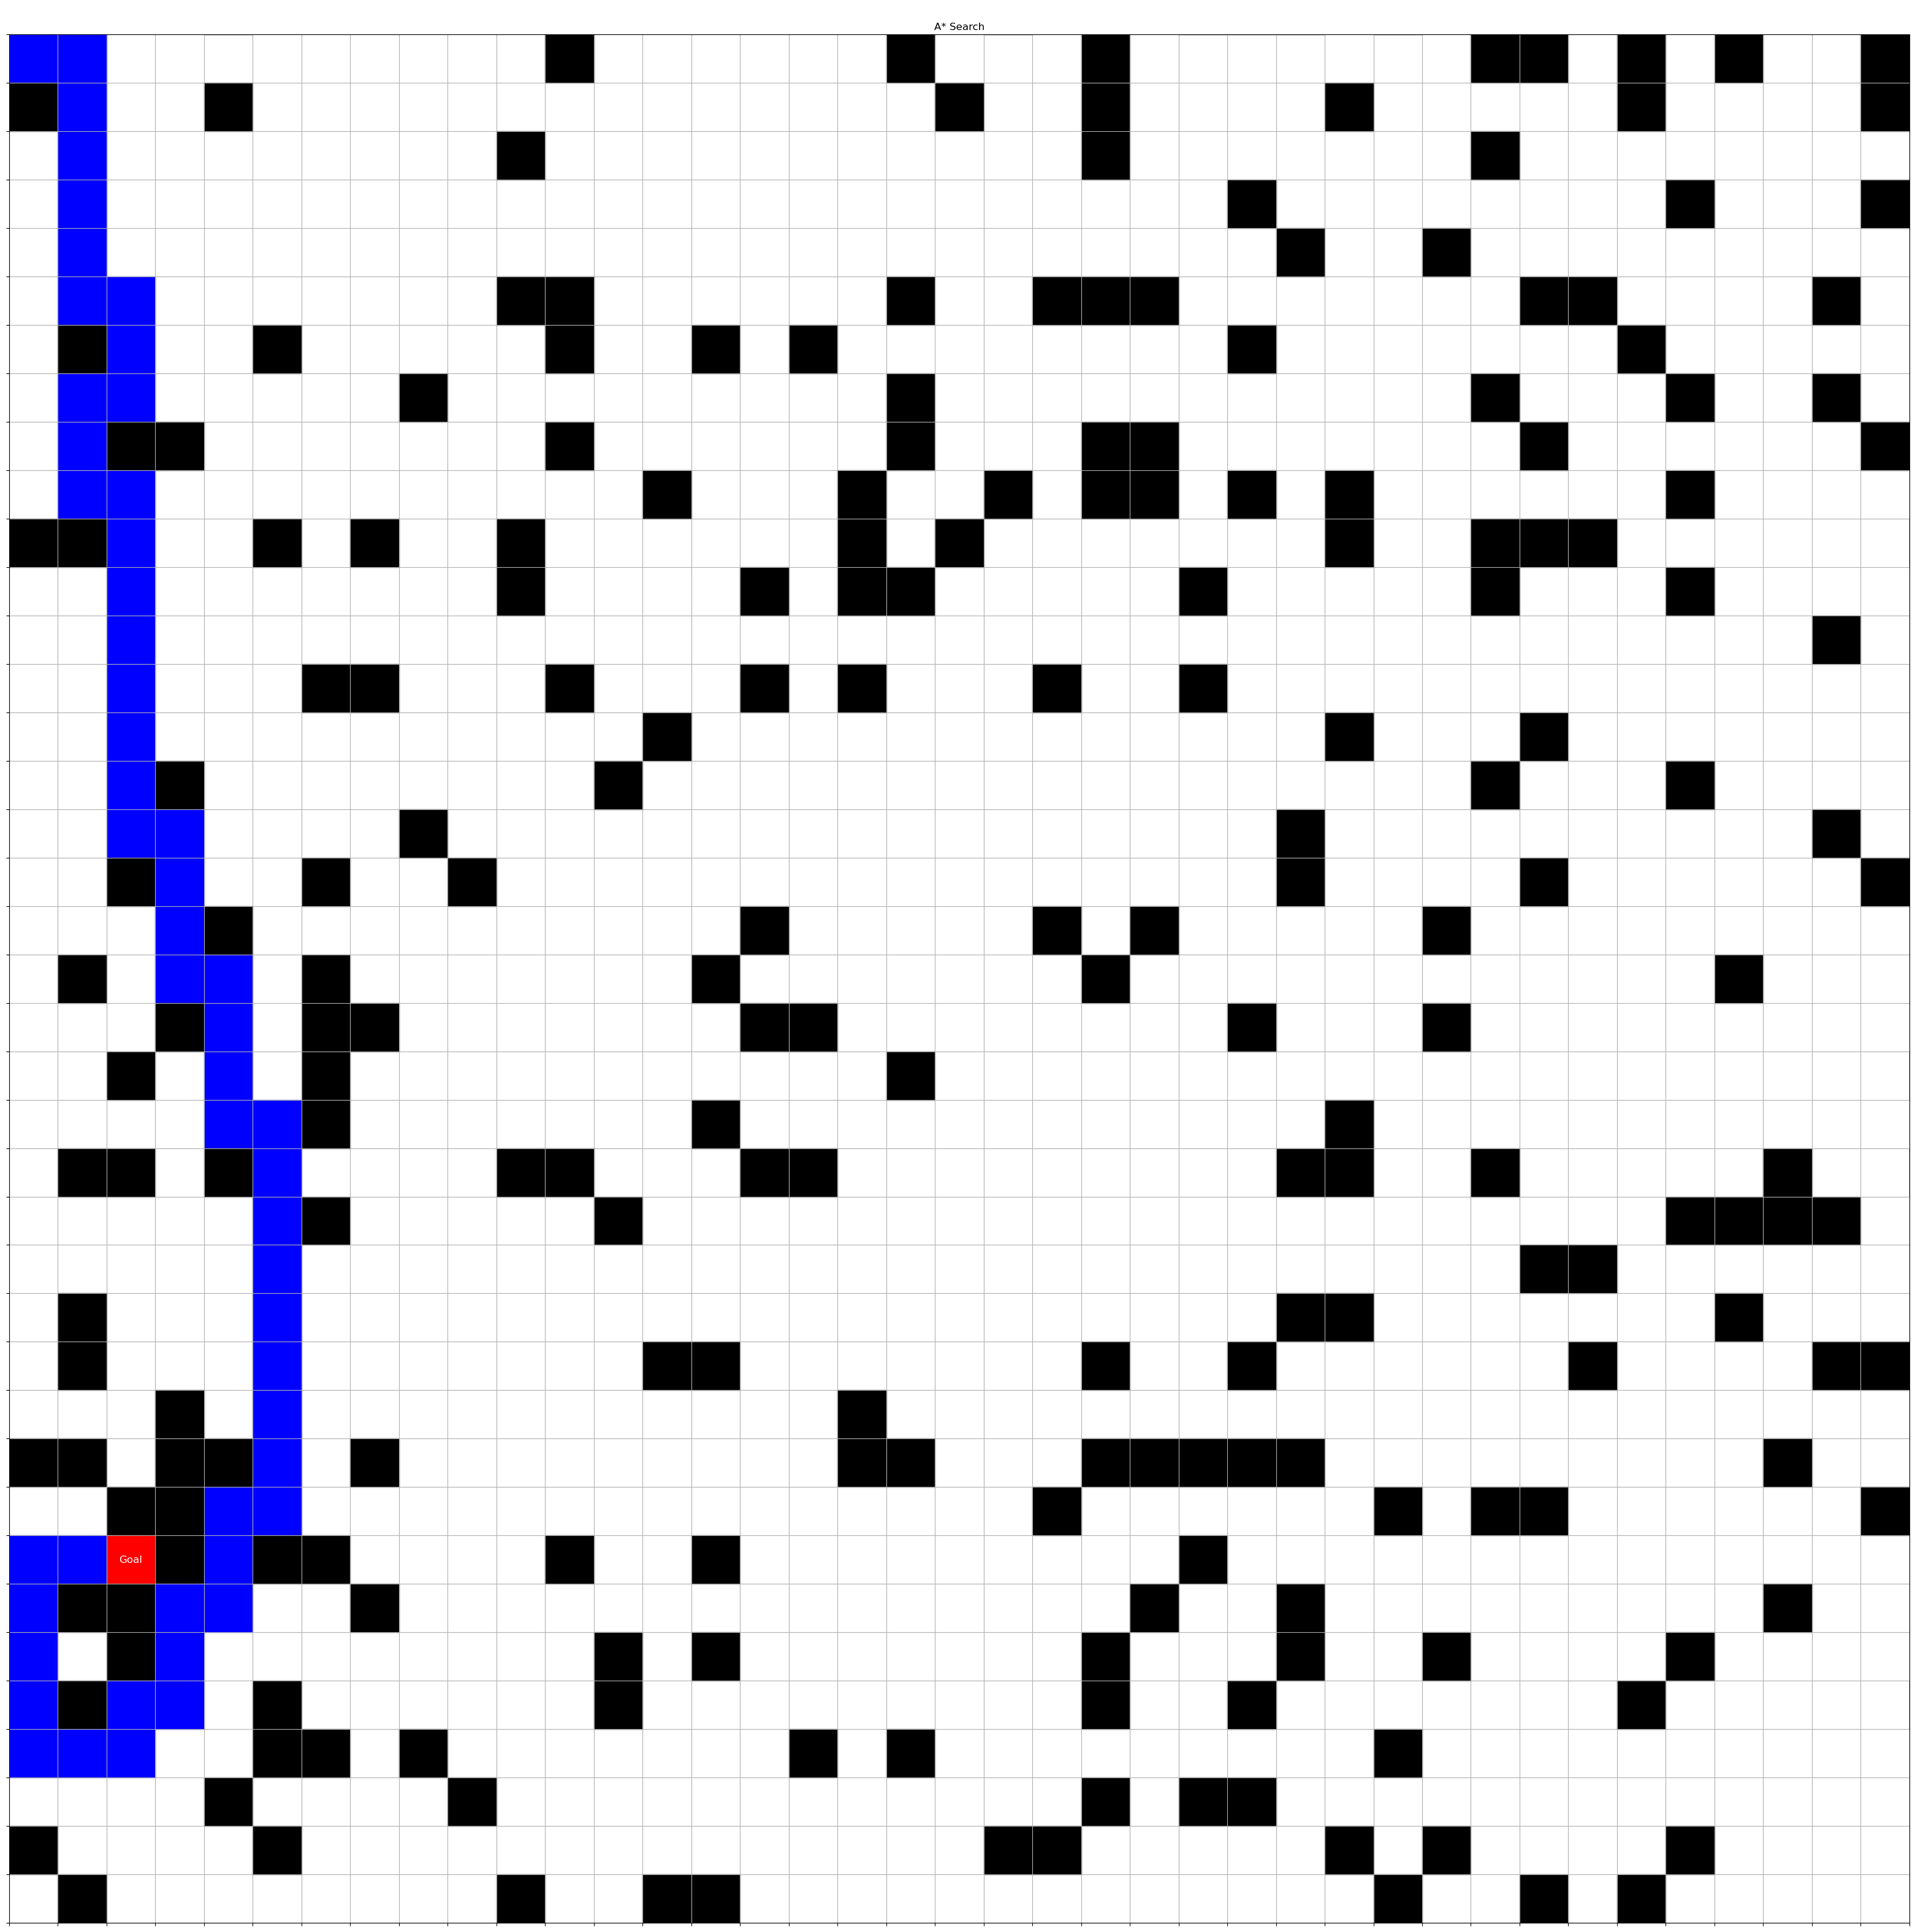

In [97]:
# Run A* search
start_position = (0, 0)
goal_position = next(node.position for node in tree.values() if node.goal)
solution_astar, _ = astar_search(tree, start_position, goal_position, verbose=True)

# Visualize the maze and the path found by A*
def visualize_maze(tree, row, col, solution=None, title="Maze"):
    fig, ax = plt.subplots(figsize=(col, row))

    for i in range(row):
        for j in range(col):
            node = tree[(i, j)]
            if not node.go:
                ax.add_patch(plt.Rectangle((j, row - i - 1), 1, 1, color='black'))
                #draw obsticles
            elif node.start:
                ax.add_patch(plt.Rectangle((j, row - i - 1), 1, 1, color='green'))
                ax.text(j + 0.5, row - i - 0.5, "S", ha='center', va='center', color='white', fontsize=12)
                #draw start state
            elif node.goal:
                ax.add_patch(plt.Rectangle((j, row - i - 1), 1, 1, color='red'))
                ax.text(j + 0.5, row - i - 0.5, "Goal", ha='center', va='center', color='white', fontsize=12)
                #draw goal state

            elif solution and node.is_part_of_solution(solution):
                ax.add_patch(plt.Rectangle((j, row - i - 1), 1, 1, color='blue'))
                #draw the path taken

    ax.set_xticks(np.arange(0, col, 1))
    ax.set_yticks(np.arange(0, row, 1))

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.grid(True)
    ax.set_title(title)
    plt.show()

visualize_maze(tree, row, col, solution_astar, title="A* Search")

__A* performance__

In [98]:
def astar_performance(tree, start_position, goal_position, verbose=False):
    """
    Calculate and display the performance of the A* search algorithm.
    """
    performance = measure_performance(astar_search, tree, start_position, goal_position, verbose=verbose)

    # Calculate performance metrics
    solution = performance['solution']
    elapsed_time = performance['elapsed_time']
    max_frontier_size = performance['max_frontier_size']

    # Display performance metrics
    print("A* Search Performance:")
    print(f"Solution: {solution}")
    print(f"Elapsed Time: {elapsed_time:.4f} seconds")
    print(f"Max Frontier Size: {max_frontier_size}")

    # Calculate and display performance in percentage
    total_nodes = len(tree)
    explored_percentage = (max_frontier_size / total_nodes) * 100
    print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

    return performance


In [99]:

astar_performance(tree, start_position, goal_position, verbose=True)

Starting A* ----->> 
Frontier size: 2
Frontier size: 2
Frontier size: 3
Frontier size: 4
Frontier size: 6
Frontier size: 8
Frontier size: 10
Frontier size: 11
Frontier size: 12
Frontier size: 13
Frontier size: 14
Frontier size: 14
Frontier size: 15
Frontier size: 17
Frontier size: 18
Frontier size: 19
Frontier size: 18
Frontier size: 19
Frontier size: 20
Frontier size: 22
Frontier size: 24
Frontier size: 26
Frontier size: 28
Frontier size: 29
Frontier size: 30
Frontier size: 31
Frontier size: 32
Frontier size: 33
Frontier size: 34
Frontier size: 35
Frontier size: 35
Frontier size: 36
Frontier size: 38
Frontier size: 39
Frontier size: 39
Frontier size: 40
Frontier size: 41
Frontier size: 43
Frontier size: 45
Frontier size: 47
Frontier size: 49
Frontier size: 48
Frontier size: 49
Frontier size: 50
Frontier size: 50
Frontier size: 50
Frontier size: 52
Frontier size: 52
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier size: 54
Frontier size: 54
Frontier size

{'solution': [(0, 0),
  (1, 0),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (6, 2),
  (7, 2),
  (8, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (10, 2),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 2),
  (15, 2),
  (16, 2),
  (17, 2),
  (17, 3),
  (18, 3),
  (19, 3),
  (20, 3),
  (20, 4),
  (21, 4),
  (22, 4),
  (23, 4),
  (23, 5),
  (24, 5),
  (25, 5),
  (26, 5),
  (27, 5),
  (28, 5),
  (29, 5),
  (30, 5),
  (31, 5),
  (31, 4),
  (32, 4),
  (33, 4),
  (33, 3),
  (34, 3),
  (35, 3),
  (35, 2),
  (36, 2),
  (36, 1),
  (36, 0),
  (35, 0),
  (34, 0),
  (33, 0),
  (32, 0),
  (32, 1),
  (32, 2)],
 'elapsed_time': 0.0,
 'max_frontier_size': 58}

__GBFS drawing in the maze__ 

Starting Greedy Best-First Search ----->> 
Frontier size: 2
Frontier size: 2
Frontier size: 3
Frontier size: 4
Frontier size: 6
Frontier size: 8
Frontier size: 10
Frontier size: 11
Frontier size: 12
Frontier size: 13
Frontier size: 14
Frontier size: 14
Frontier size: 15
Frontier size: 16
Frontier size: 17
Frontier size: 18
Frontier size: 19
Frontier size: 21
Frontier size: 23
Frontier size: 25
Frontier size: 27
Frontier size: 28
Frontier size: 29
Frontier size: 30
Frontier size: 31
Frontier size: 32
Frontier size: 33
Frontier size: 34
Frontier size: 35
Frontier size: 37
Frontier size: 38
Frontier size: 38
Frontier size: 39
Frontier size: 40
Frontier size: 42
Frontier size: 44
Frontier size: 46
Frontier size: 48
Frontier size: 47
Frontier size: 48
Frontier size: 49
Frontier size: 49
Frontier size: 49
Frontier size: 51
Frontier size: 51
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier 

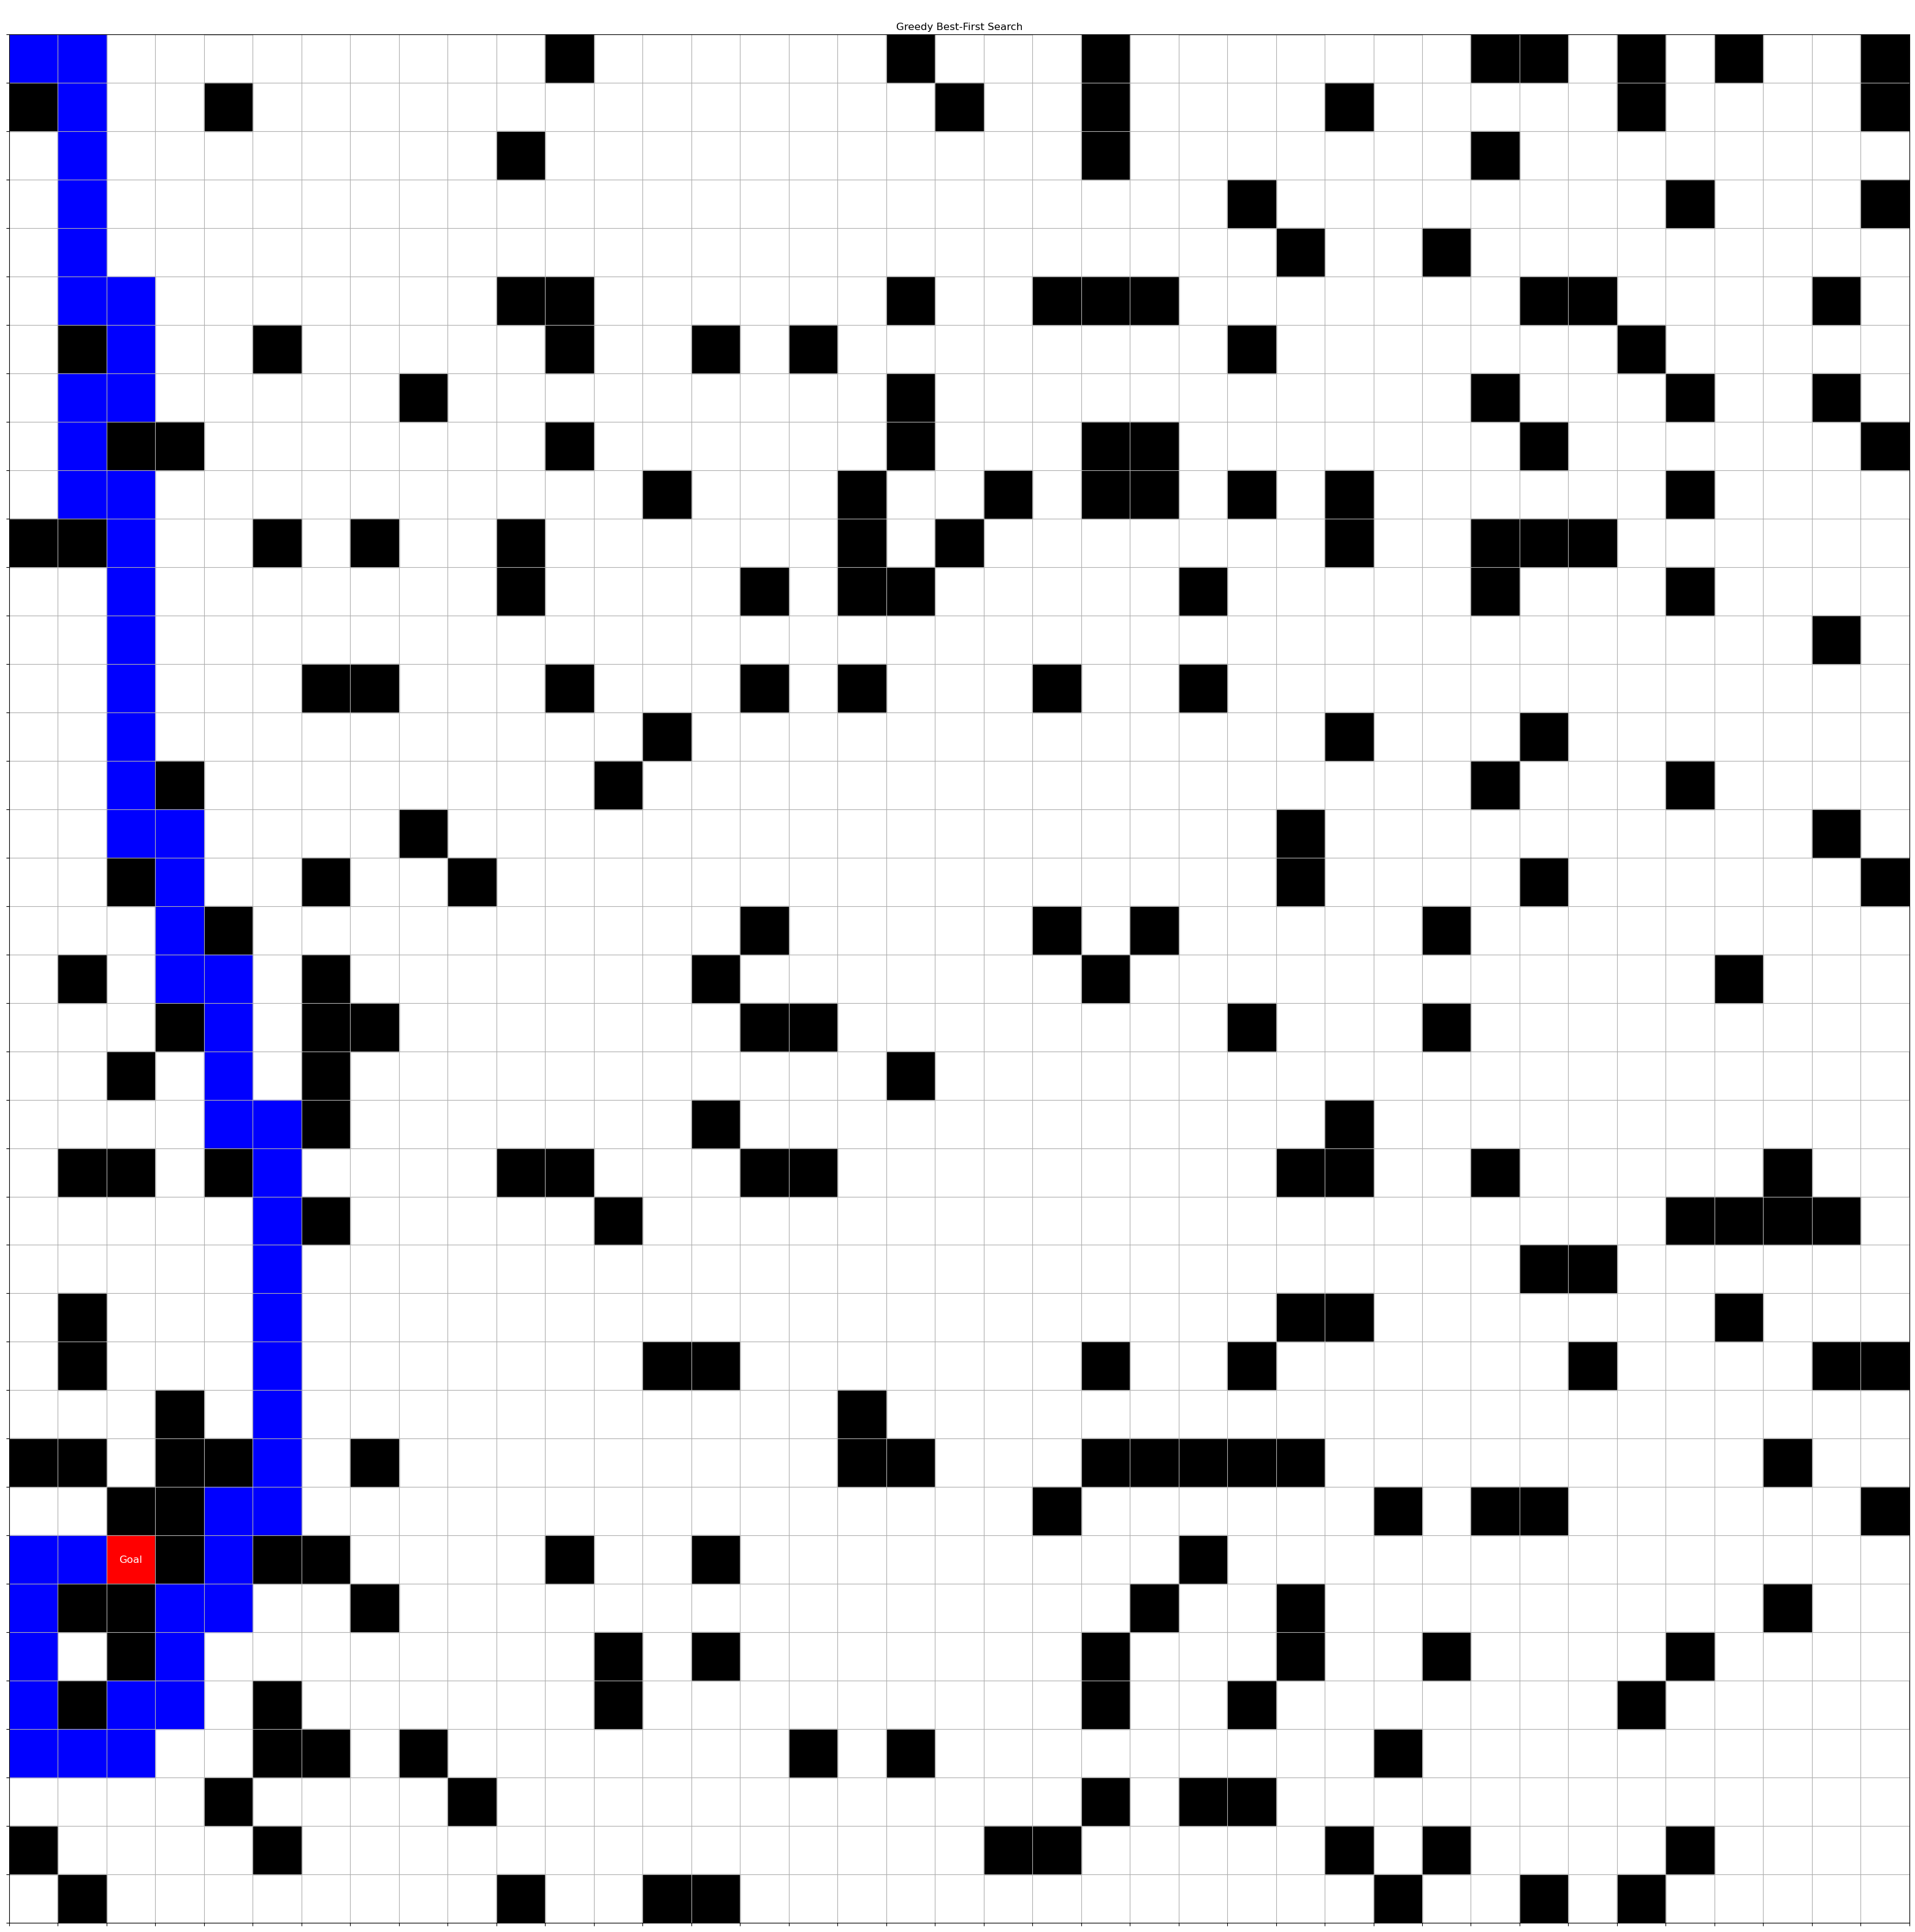

In [100]:

solution_gbfs, _ = Greedy_best_firsy_search(tree, start_position, goal_position, verbose=True)

visualize_maze(tree, row, col, solution_gbfs, title="Greedy Best-First Search")


__GBFS performance__

In [ ]:
def gbfs_performance(tree, start_position, goal_position, verbose=False):
    """
    Calculate and display the performance of the Greedy Best-First Search algorithm.
    """
    performance = measure_performance(Greedy_best_firsy_search, tree, start_position, goal_position, verbose=verbose)

    solution = performance['solution']
    elapsed_time = performance['elapsed_time']
    max_frontier_size = performance['max_frontier_size']

    print("Greedy Best-First Search Performance:")
    print(f"Path: {solution}")
    print(f"Elapsed Time: {elapsed_time:.4f} seconds")
    print(f"Max Frontier Size: {max_frontier_size}")

    total_nodes = len(tree)
    explored_percentage = (max_frontier_size / total_nodes) * 100
    print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

    return performance


In [102]:

gbfs_performance(tree, start_position, goal_position, verbose=True)


Starting Greedy Best-First Search ----->> 
Frontier size: 2
Frontier size: 2
Frontier size: 3
Frontier size: 4
Frontier size: 6
Frontier size: 8
Frontier size: 10
Frontier size: 11
Frontier size: 12
Frontier size: 13
Frontier size: 14
Frontier size: 14
Frontier size: 15
Frontier size: 16
Frontier size: 17
Frontier size: 18
Frontier size: 19
Frontier size: 21
Frontier size: 23
Frontier size: 25
Frontier size: 27
Frontier size: 28
Frontier size: 29
Frontier size: 30
Frontier size: 31
Frontier size: 32
Frontier size: 33
Frontier size: 34
Frontier size: 35
Frontier size: 37
Frontier size: 38
Frontier size: 38
Frontier size: 39
Frontier size: 40
Frontier size: 42
Frontier size: 44
Frontier size: 46
Frontier size: 48
Frontier size: 47
Frontier size: 48
Frontier size: 49
Frontier size: 49
Frontier size: 49
Frontier size: 51
Frontier size: 51
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 52
Frontier size: 53
Frontier size: 53
Frontier size: 53
Frontier 

{'solution': [(0, 0),
  (1, 0),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (6, 2),
  (7, 2),
  (8, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (10, 2),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 2),
  (15, 2),
  (16, 2),
  (17, 2),
  (17, 3),
  (18, 3),
  (19, 3),
  (20, 3),
  (20, 4),
  (21, 4),
  (22, 4),
  (23, 4),
  (23, 5),
  (24, 5),
  (25, 5),
  (26, 5),
  (27, 5),
  (28, 5),
  (29, 5),
  (30, 5),
  (31, 5),
  (31, 4),
  (32, 4),
  (33, 4),
  (33, 3),
  (34, 3),
  (35, 3),
  (35, 2),
  (36, 2),
  (36, 1),
  (36, 0),
  (35, 0),
  (34, 0),
  (33, 0),
  (32, 0),
  (32, 1),
  (32, 2)],
 'elapsed_time': 0.0023298263549804688,
 'max_frontier_size': 57}